# Seminar 7: Efficient model inference

As we now know from the lecture, there are many ways to make inference more efficient:
- Distillation
- Quantization
- Changing architecture (e.g. encoder-decoder vs decoder)
- Speculative decoding

In the seminar we will talk about different kinds of **post-training quantization**.

For more info about quantization, a good starting point is ["A Survey of Quantization Methods for Efficient Neural Network Inference"](https://arxiv.org/abs/2103.13630), 2021.

### Plan:

1. Some notes about Memory Bandwidth Utilization
2. Data-free quantization with T5
3. Weight-only Quantization with calibration (GPTq)
4. Weight & Activation Quantization (SmoothQuant)

## 1: Memory Bandwidth Utilization (MBU)

Let's read the following passage from [this post](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices) by Databricks.

> So, how exactly should we think about inference speed?
Our _[Databricks]_ team uses four key metrics for LLM serving:
> 1. **Time To First Token (TTFT)**: How quickly users start seeing the model's output after entering their query. Low waiting times for a response are essential in real-time interactions, but less important in offline workloads. This metric is driven by the time required to process the prompt and then generate the first output token.
> 2. **Time Per Output Token (TPOT)**: Time to generate an output token for each user that is querying our system. This metric corresponds with how each user will perceive the "speed" of the model. For example, a TPOT of 100 milliseconds/tok would be 10 tokens per second per user, or ~450 words per minute, which is faster than a typical person can read.
> 3. **Latency**: The overall time it takes for the model to generate the full response for a user. Overall response latency can be calculated using the previous two metrics: latency = (TTFT) + (TPOT) * (the number of tokens to be generated)
>4. **Throughput**: The number of output tokens per second an inference server can generate across all users and requests


> To measure the underlying hardware's utilization, we introduce a new metric called Model Bandwidth Utilization (MBU).
> MBU is defined as

$$\frac{\text{achieved memory bandwidth}}{\text{peak memory bandwidth}}$$

>where

$$
\text{achieved memory bandwidth} = \frac{\text{total model parameter size + KV cache size}}{\text{TPOT}}
$$

![](memory_bandwidth_utilization.jpg)

### Example on how to estimate MBU

- For example, if a 7B parameter running with 16-bit precision has TPOT equal to 14ms, then it's moving 14GB of parameters in 14ms translating to 1TB/sec bandwidth usage.
- A100 can handle up to ~2Tb/sec.
- So, we are running at an MBU of 50%.

## 2: Data-free quantization with t5

First let's try data-free quantization, initially proposed in ["QLoRA: Efficient Finetuning of Quantized LLMs"](https://arxiv.org/abs/2305.14314).

(Section is based on this [post](https://huggingface.co/blog/hf-bitsandbytes-integration).)

In [1]:
import os

# autogptq can be very slow if you don't restrict the amount of CPU cores it is using
max_cpu_threads = "16"
os.environ["OMP_NUM_THREADS"] = max_cpu_threads
os.environ["OPENBLAS_NUM_THREADS"] = max_cpu_threads
os.environ["MKL_NUM_THREADS"] = max_cpu_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = max_cpu_threads
os.environ["NUMEXPR_NUM_THREADS"] = max_cpu_threads
os.environ["NUMEXPR_MAX_THREADS"] = max_cpu_threads

In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig

In [5]:
! pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.7 MB/s eta 0:00:00


In [3]:
model_name = "t5-3b-sharded"

# T5-3b and T5-11B are supported!
# We need sharded weights otherwise we get CPU OOM errors
model_id = f"ybelkada/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_8bit = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True
    ),
    device_map="auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin.index.json:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

pytorch_model_00001-of-00005.bin:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

pytorch_model_00002-of-00005.bin:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

pytorch_model_00003-of-00005.bin:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

pytorch_model_00004-of-00005.bin:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

pytorch_model_00005-of-00005.bin:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
model_8bit.get_memory_footprint() / 1e9

5.300543488

For t5-3b the int8 model is about ~5.3GB! whereas the original model has 11GB.

For t5-11b the int8 model is about ~11GB vs 42GB for the original model. Now let's generate and see the qualitative results of the 8bit model!

In [5]:
max_new_tokens = 50

input_ids = tokenizer(
    "translate English to German: Hello my name is Younes and I am a Machine Learning Engineer at Hugging Face",
    return_tensors="pt",
).input_ids.to("cuda:0")

outputs = model_8bit.generate(input_ids, max_new_tokens=max_new_tokens)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hallo mein Name ist Younes und ich bin ein Machine Learning Ingenieur bei Hugging Face


In [6]:
torch.cuda.max_memory_allocated() / 1e9

5.356438016

In [7]:
del model_8bit, tokenizer

In [8]:
# https://stackoverflow.com/questions/57858433/how-to-clear-gpu-memory-after-pytorch-model-training-without-restarting-kernel
import gc
torch.cuda.empty_cache()
gc.collect()

torch.cuda.reset_peak_memory_stats()
torch.cuda.max_memory_allocated() / 1e9

0.008520704

## 3: Weight-only quantization with calibration dataset (GPTq)

Data-free quantization usually does something like
$$
\arg\min \|W - W_{\text{quantized}}\|_{F}
$$
It is simple and easy to use. However, this does not acoount for the fact, that we apply our models on a specific distribution of data.

Let's $X$ to be activation from previous layers. Then we might formulate quantization objective as
$$
\arg\min \|X \cdot W - X \cdot W_{\text{quantized}}\|_{F}
$$
The intuition is that we want to preserve _the way layer $W$ transforms the inputs_, not its literal weights.
This is one of the core ideas used in GPTq algorithm.

(Based on [AutoGPTq tutorial](https://github.com/AutoGPTQ/AutoGPTQ/tree/main))

### Setting up

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


model_name = "meta-llama/Llama-2-7b-hf"
# model_name = 'RicardoLee/Llama2-base-7B-Chinese-50W-LoRA'
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    local_files_only=False,
    low_cpu_mem_usage=True, # speeds up loading, if `accelerate` is installed
    token=token
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [11]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

In [12]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"{count_params(model) // 1e6:4.0f} M parameters")
print(f"{count_params(model.model.embed_tokens) // 1e6:4.0f} M parameters in embedding block")

6738 M parameters
 131 M parameters in embedding block


In [13]:
device = torch.device("cuda:0")
model = model.to(device)

In [14]:
@torch.inference_mode()
def generate(model, tokenizer, prefix, max_length, device="cuda:0") -> str:
    inputs = tokenizer(prefix, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        repetition_penalty=1.1,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [15]:
import time
from tqdm.auto import tqdm

prompts = [f"You will never believe this wild conspiracy theory about {topic}:"
    for topic in ("bananas", "grizzly bears", "gummy bears", "Python language", "Yann LeCun")]

max_length = 384

start = time.perf_counter()
answers = [generate(model, tokenizer, prompt, max_length) for prompt in tqdm(prompts)]
generation_time = time.perf_counter() - start

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
print(answers[4])

You will never believe this wild conspiracy theory about Yann LeCun: He thinks AI is a good thing
It's all part of the "AI Winter" conspiracy.
By Kyle Wiggers on July 10, 2017
Credit: BENJAMIN CURTIS/AFP/Getty Images
When it comes to artificial intelligence, there are two camps: those who see it as an existential threat and those who see it as an existential boon. The former include Elon Musk, Stephen Hawking, and Bill Gates; the latter include Mark Zuckerberg and Yann LeCun.
LeCun, Facebook’s chief AI scientist and one of the world’s leading researchers in deep learning, is a vocal proponent of AI. He recently told The Verge that he doesn’t think AI will take over humanity anytime soon — and if it does, we’ll be better off for it.
SEE ALSO: It's time to stop demonizing artificial intelligence
“I don’t think I have anything to worry about,” he said. “I don’t think we should be worried about being replaced by machines.”
As for his stance on AI, LeCun said it was rooted in pragmatism. Wh

Let's calculate MBU for this model.

In [17]:
n_generated_tokens_total = sum([len(answer) - len(prompt)
                                for answer, prompt in zip(tokenizer(answers).input_ids, tokenizer(prompts).input_ids)])
n_generated_tokens_total

1334

In [18]:
print(f"Generation speed: {n_generated_tokens_total / generation_time:.1f} tokens/sec")

Generation speed: 31.8 tokens/sec


In [19]:
def compute_model_size_mb(model):
    model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / 1e6
    model_size_mb += sum(b.numel() * b.element_size() for b in model.buffers()) / 1e6
    return model_size_mb

def compute_memory_bandwidth_utilization(model_and_kv_cache_size_mb, max_bandwidth_mb, time_per_output_token):
    return (model_and_kv_cache_size_mb / time_per_output_token) / max_bandwidth_mb

In [20]:
model_size_mb = compute_model_size_mb(model)

# 2 * batch_size * sequence_length * n_layers * (n_heads * d_head) * precision
kv_cache_size_mb = 2 * 1 * max_length * model.config.num_hidden_layers * model.config.hidden_size * 2 / 1e6

a100_max_bandwidth_mb = 2e6

mbu = compute_memory_bandwidth_utilization(
    model_size_mb + kv_cache_size_mb,
    a100_max_bandwidth_mb,
    generation_time / n_generated_tokens_total
)

print(f"Memory Bandwidth Utilization is {mbu * 100:.2f} %")

Memory Bandwidth Utilization is 21.77 %


In [21]:
print(f"Model size: {model_size_mb:.0f} Mb")
print(f"KV cache size: {kv_cache_size_mb:.0f} Mb")

Model size: 13477 Mb
KV cache size: 201 Mb


In [22]:
del model, tokenizer

In [24]:
torch.cuda.empty_cache()
gc.collect()

torch.cuda.reset_peak_memory_stats()
torch.cuda.max_memory_allocated() / 1e9

13.485368832

### Run AutoGPTq

Let's prepare a calibration dataset.

In [ ]:
! pip install datasets

In [26]:
from datasets import load_dataset

n_samples = 128
dataset = load_dataset("wikitext", "wikitext-2-v1", split="test")

calibration_set = dataset.filter(lambda example: len(example["text"]) > 100)
calibration_set = calibration_set.shuffle(seed=59)[:n_samples]["text"]

len(calibration_set)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

128

In [27]:
calibration_set[:2]

[' On the January 25 episode of Raw , Stephanie McMahon announced that the main event of <unk> would be a triple threat match between <unk> , Roman <unk> , and Dean <unk> to determine who would face Triple H for the WWE World Heavyweight Championship at WrestleMania 32 . In the following weeks , <unk> would be continuously provoked by <unk> , with <unk> saving him from the subsequent attacks by <unk> . At <unk> , <unk> dominated most of the match before he was put through two announce tables by <unk> and <unk> ; he would ultimately lose the match after <unk> pinned <unk> . Because of this , <unk> attacked <unk> in the parking lot as he was arriving at the arena for Raw , but <unk> would return later in the night , having <unk> an ambulance , and he challenged <unk> to a No <unk> <unk> Street Fight match at WrestleMania 32 , where <unk> defeated <unk> . On the July 7 edition of SmackDown , it was announced that <unk> would be facing the returning Randy <unk> at SummerSlam . On July 19 ,

Now we can run GPTq.

In [ ]:
! pip install auto_gptq

In [3]:
from transformers import AutoTokenizer, TextGenerationPipeline
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
import logging

In [ ]:
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s", level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S"
)
model_name = 'meta-llama/Llama-2-7b-hf'
quantized_model_dir = model_name + "_4bit"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)


device = 'cuda'

quantize_config = BaseQuantizeConfig(
    bits=4,          # quantize model to 4-bit
    group_size=128,  # it is recommended to set the value to 128
    desc_act=False,  # set to False can significantly speed up inference but the perplexity may slightly bad
)

examples = [tokenizer(sample, return_tensors="pt").to(device) for sample in calibration_set]

In [31]:
# load un-quantized model, by default, the model will always be loaded into CPU memory
model = AutoGPTQForCausalLM.from_pretrained(
    model_name,
    quantize_config,
    local_files_only=False,
    low_cpu_mem_usage=True,
)
model.to(device)

# quantize model, the examples should be list of dict whose keys can only be "input_ids" and "attention_mask"
model.quantize(examples)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Start quantizing layer 1/32
INFO:auto_gptq.modeling._base:Start quantizing layer 1/32
INFO - Quantizing self_attn.k_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing self_attn.k_proj in layer 1/32...
INFO - Quantizing self_attn.v_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing self_attn.v_proj in layer 1/32...
INFO - Quantizing self_attn.q_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing self_attn.q_proj in layer 1/32...
INFO - Quantizing self_attn.o_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing self_attn.o_proj in layer 1/32...
INFO - Quantizing mlp.up_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing mlp.up_proj in layer 1/32...
INFO - Quantizing mlp.gate_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing mlp.gate_proj in layer 1/32...
INFO - Quantizing mlp.down_proj in layer 1/32...
INFO:auto_gptq.modeling._base:Quantizing mlp.down_proj in layer 1/32...
INFO - Start quantizing layer 2/32
INFO:

### Save quantized model

In [32]:
# save quantized model using safetensors
model.save_quantized(quantized_model_dir)

### Check how quantized model generates

In [ ]:
# load quantized model to the first GPU
model = AutoGPTQForCausalLM.from_quantized(
    quantized_model_dir,
    low_cpu_mem_usage=True,
    device=device,
)

What size we should expect before and after quantization?

In [ ]:
print(f"Before quantization: {model_size_mb:.0f} Mb")

In [ ]:
model_size_mb = compute_model_size_mb(model)
print(f"After quantization: {model_size_mb:.0f} Mb")

Quantized model has more than x3 smaller memory footprint. You can almost run it on a toaster now.

In [ ]:
start = time.perf_counter()
answers = [generate(model, tokenizer, prompt, max_length) for prompt in tqdm(prompts)]
generation_time = time.perf_counter() - start

In [ ]:
print(answers[4])

In [ ]:
n_generated_tokens_total = sum([len(answer) - len(prompt)
                                for answer, prompt in zip(tokenizer(answers).input_ids, tokenizer(prompts).input_ids)])
n_generated_tokens_total

In [ ]:
print(f"Generation speed: {n_generated_tokens_total / generation_time:.1f} tokens/sec")

Having compressed the model, we might have hoped for speedup. However, memory transfers are not the only bottleneck, and there might be some inefficiencies in implementation, which slow us down.

GPTq still can noticeably drive the memory footprint down, and this is often vital when you work on a small GPU.

In [ ]:
mbu = compute_memory_bandwidth_utilization(
    model_size_mb + kv_cache_size_mb,
    a100_max_bandwidth_mb,
    generation_time / n_generated_tokens_total
)

print(f"Memory Bandwidth Utilization is {mbu * 100:.2f} %")

In [ ]:
del model, examples, tokenizer

NameError: name 'model' is not defined

In [ ]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.max_memory_allocated() / 1e9


28.18325504

## 4: Weight & Activation Quantization (SmoothQuant)

Weight-only quantization helps to improve Memory Bandwidth Utilization. Therefore, it primarily provides speedups at low batch sizes and for autoregressive generation tasks.

To make models faster when you have large batch sizes or don't have to autoregressively generate responces, you can use weight and activation quantization.

By converting weights and activations e.g. from fp16 to int8, we can utilize efficient `GEMM` and `BMM` kernels and theoretically double the throughput.

Current part is a copy of this [example](https://github.com/mit-han-lab/smoothquant/blob/main/examples/smoothquant_llama_demo.ipynb).

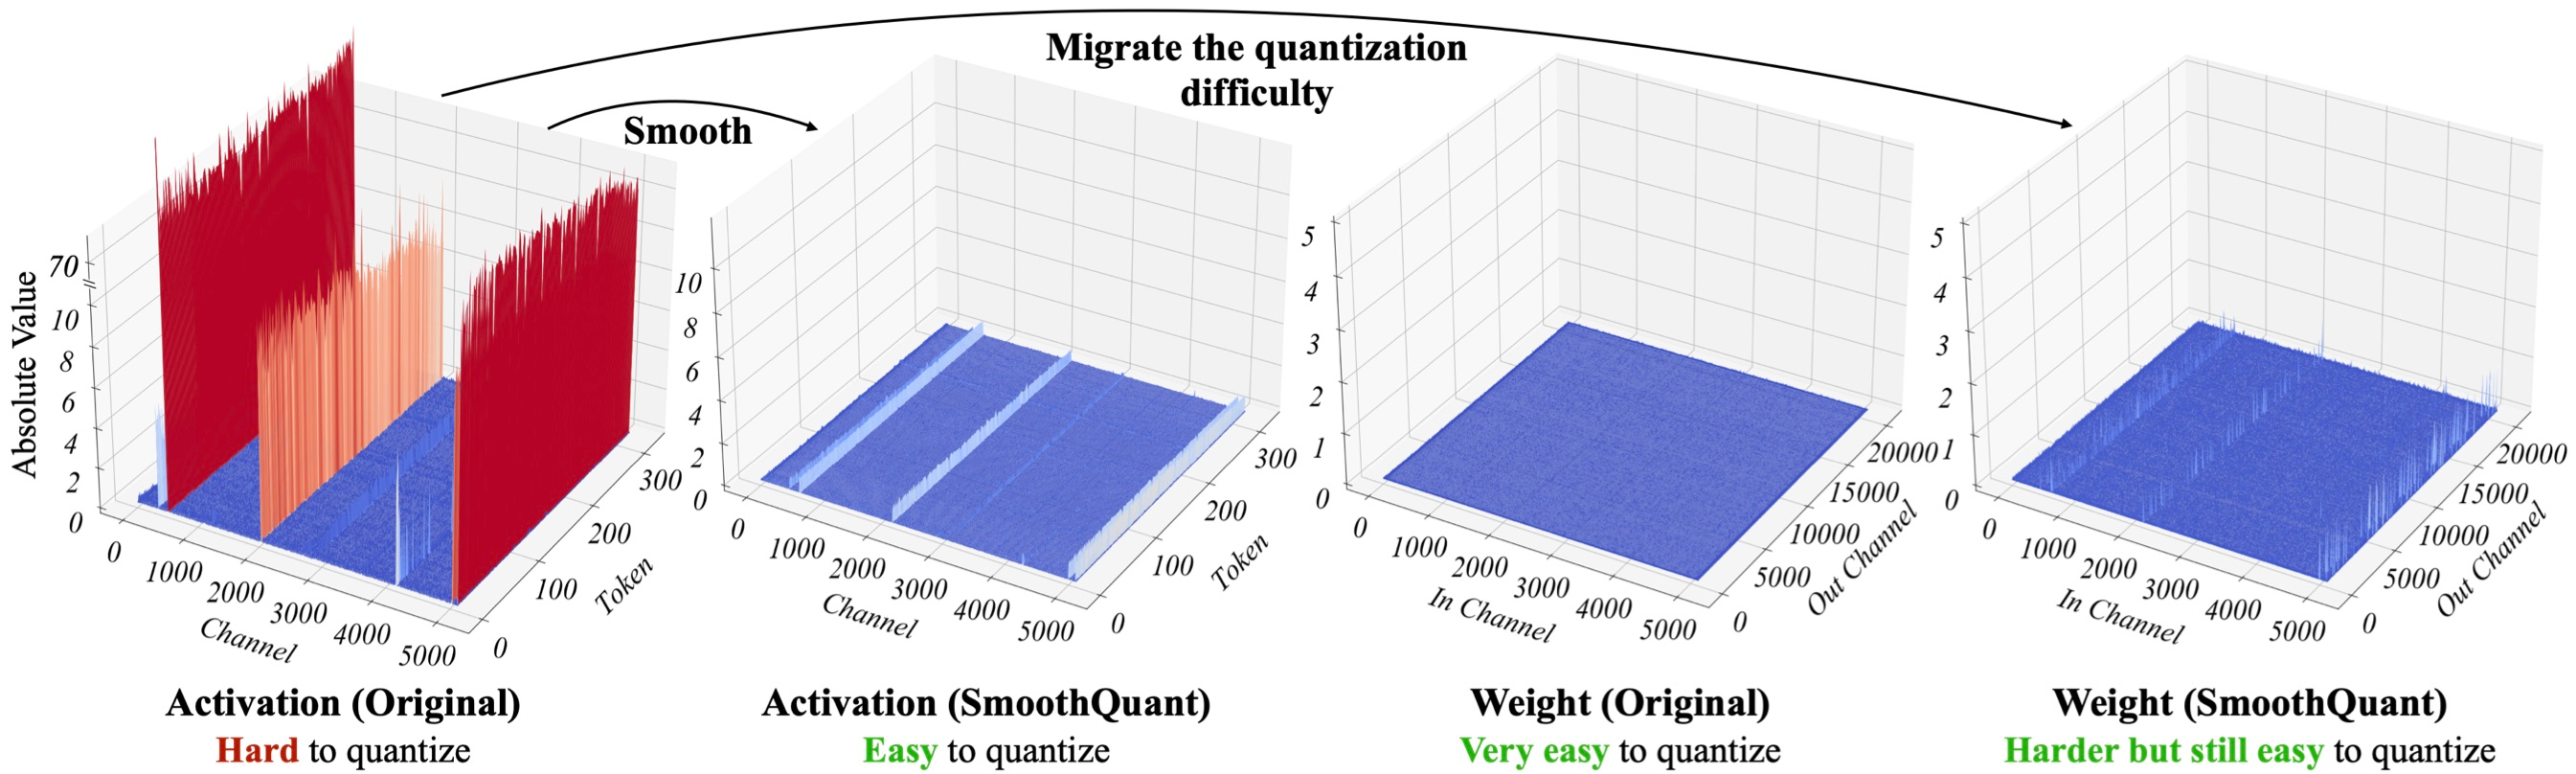

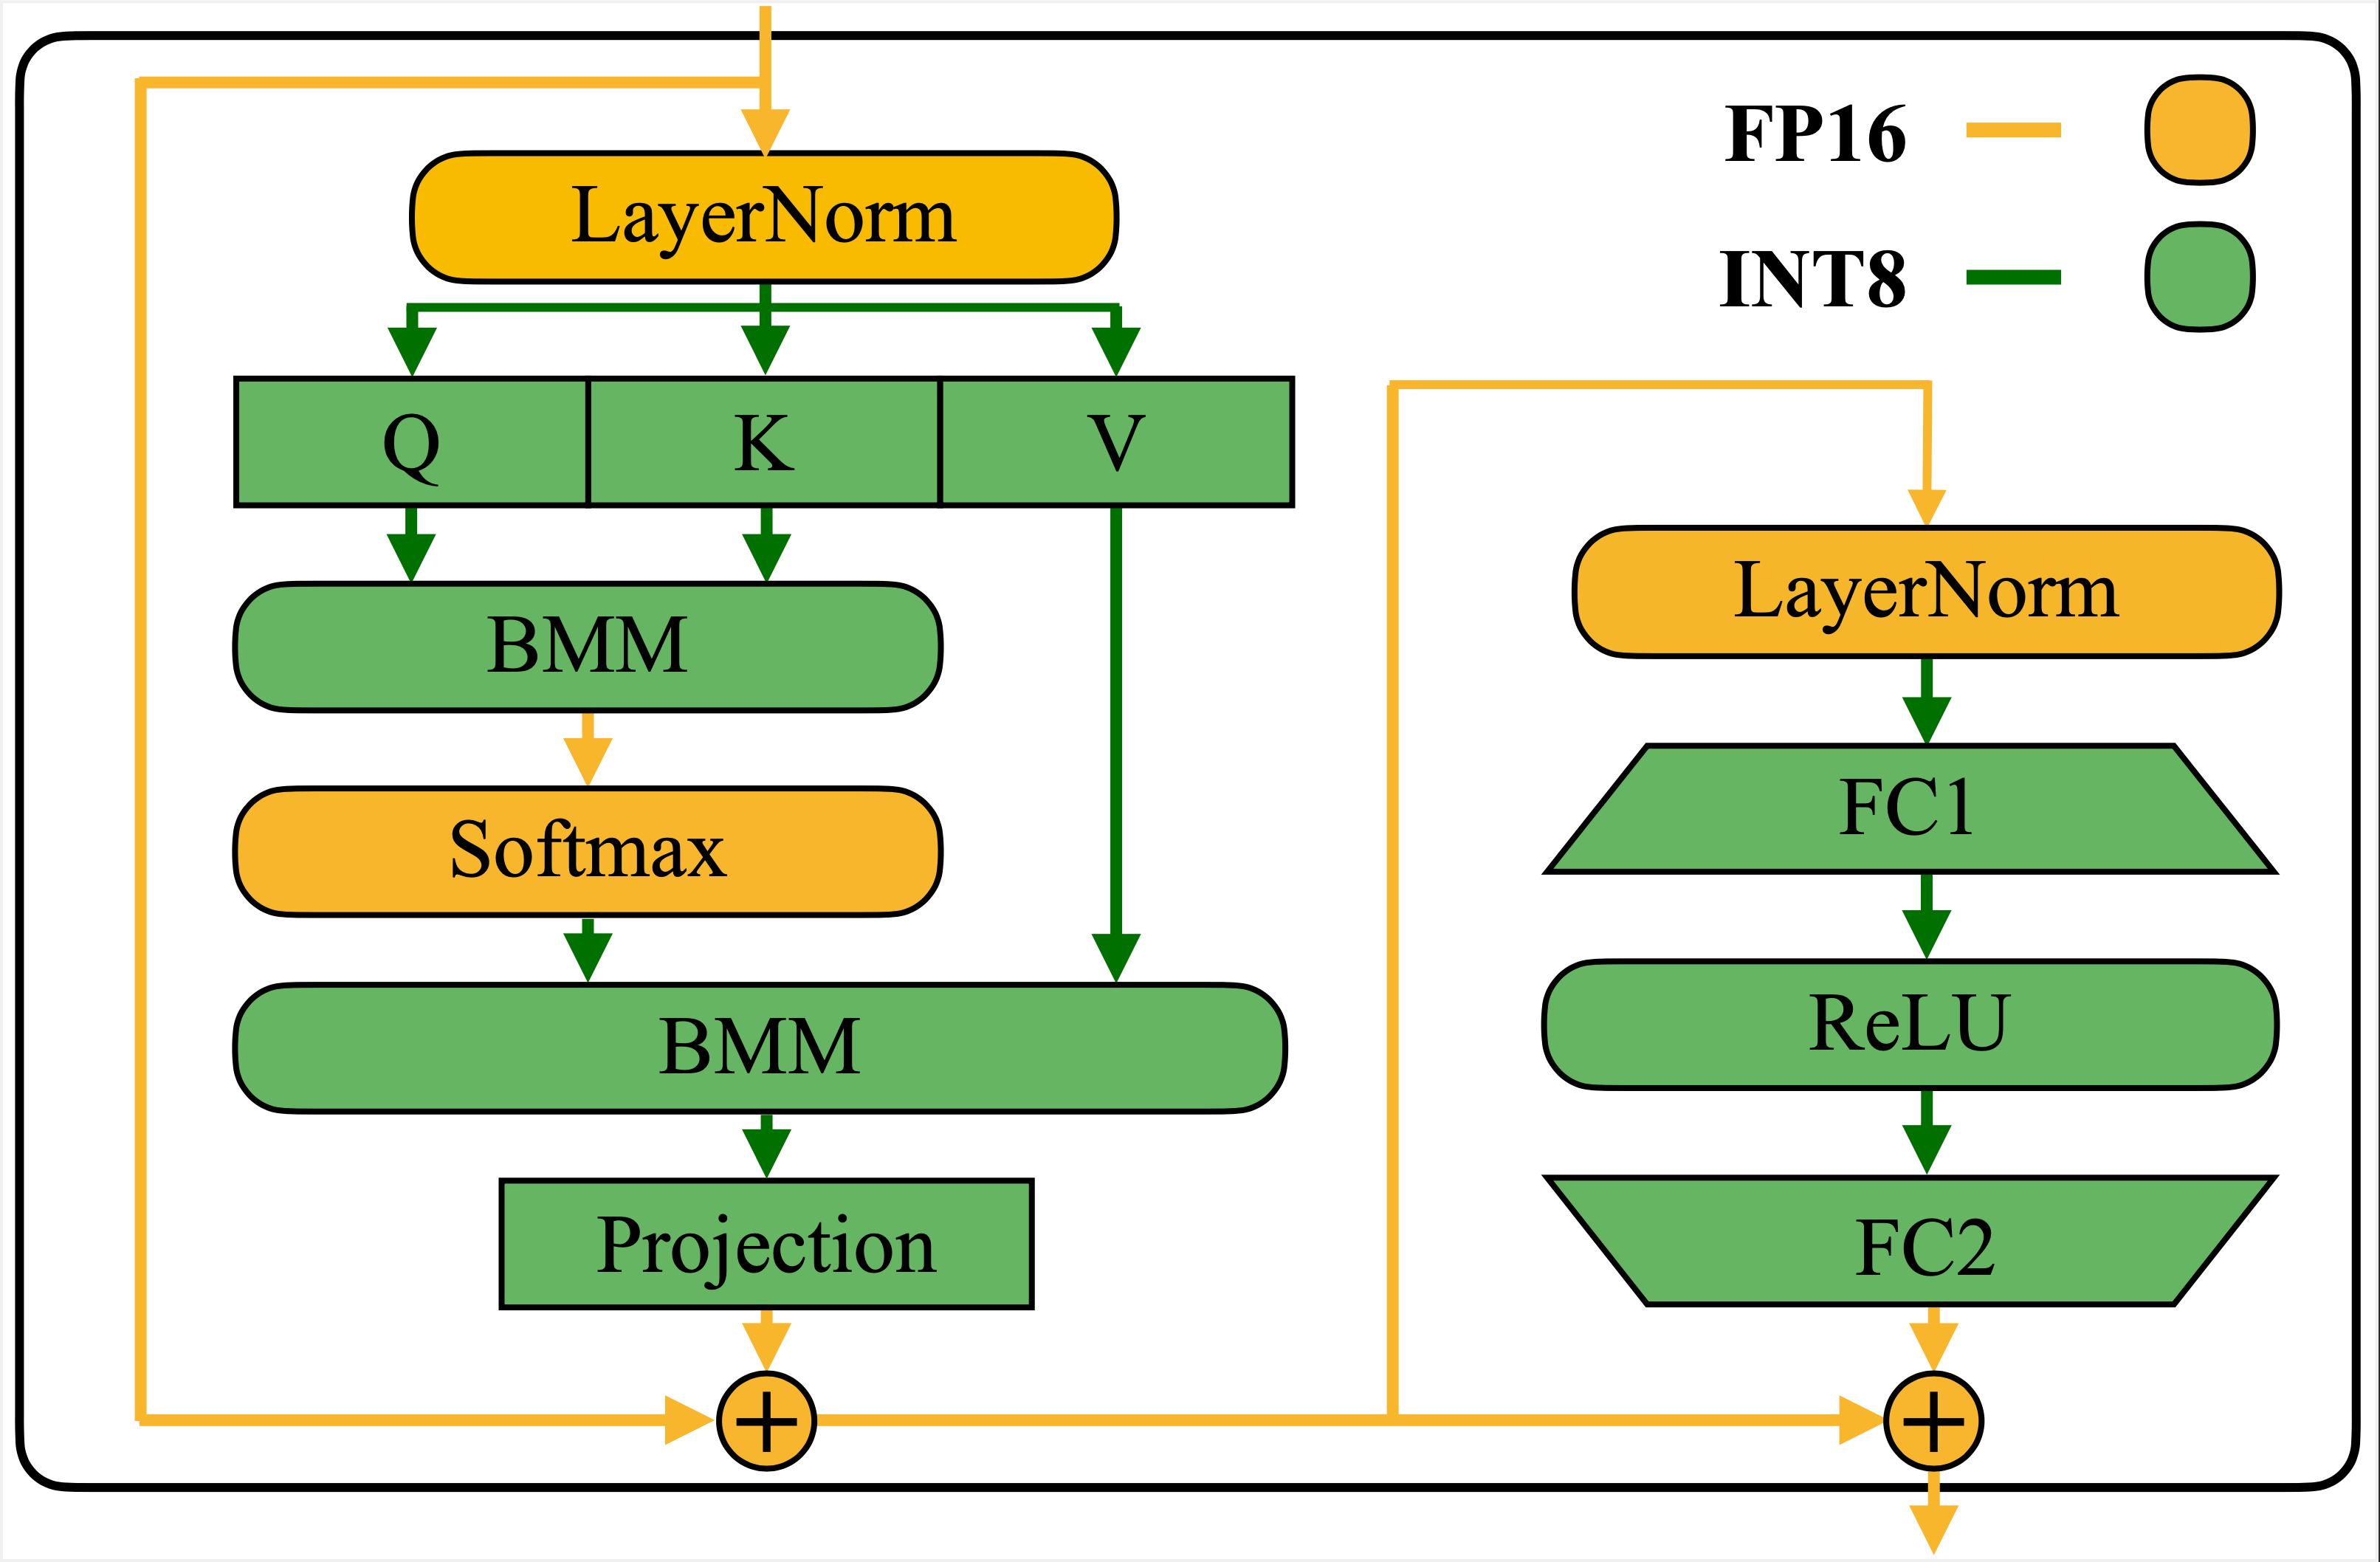

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
! pip install transformers==4.36.0 accelerate datasets zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    F

In [4]:
# ! pip install smoothquant

! pip install git+https://github.com/mit-han-lab/smoothquant.git

  Cloning https://github.com/mit-han-lab/smoothquant.git to /tmp/pip-req-build-ygcfptnb
  Running command git clone --filter=blob:none --quiet https://github.com/mit-han-lab/smoothquant.git /tmp/pip-req-build-ygcfptnb
  Resolved https://github.com/mit-han-lab/smoothquant.git to commit c61476d728e42ae0d8a35e7e78494edcac3237b5
  Preparing metadata (setup.py) ... done
  Created wheel for smoothquant: filename=smoothquant-0.0.0-py3-none-any.whl size=11948 sha256=ed9f23b5fe577e2763713786307f82f409e9245d0c9fad733d83385af73d1e39
  Stored in directory: /tmp/pip-ephem-wheel-cache-7d48vald/wheels/48/54/db/a95fd980c7ba8489e079984bde7525235f16f3fbb6962a42bd
Successfully built smoothquant


In [5]:
import torch
import torch.nn as nn
from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    LlamaDecoderLayer,
    LlamaForCausalLM,
    LlamaMLP,
)
from transformers import LlamaTokenizer
import smoothquant
from smoothquant.smooth import smooth_lm
from smoothquant.fake_quant import quantize_llama_like
import tqdm

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


> The following is an evaluator to see the performance of the model. We use a toy dataset (the first 40 examples in the test set of the Wikitext-2 dataset) to evaluate the model. You can replace it with your own dataset. The conclusion should be the same.

In [6]:
class Evaluator:
    def __init__(self, dataset, tokenizer, device, n_samples=40):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.device = device

        self.dataset = tokenizer(
            "\n\n".join(dataset["text"]), return_tensors="pt"
        ).input_ids.to(device)

        self.n_samples = n_samples

    @torch.no_grad()
    def evaluate(self, model):
        model.eval()
        nlls = []
        for i in tqdm.tqdm(range(self.n_samples), desc="Evaluating..."):
            batch = self.dataset[:, (i * 2048) : ((i + 1) * 2048)].to(model.device)
            with torch.no_grad():
                lm_logits = model(batch).logits
            shift_logits = lm_logits[:, :-1, :].contiguous().float()
            shift_labels = self.dataset[:, (i * 2048) : ((i + 1) * 2048)][:, 1:]
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
            )
            neg_log_likelihood = loss.float() * 2048
            nlls.append(neg_log_likelihood)

        return torch.exp(torch.stack(nlls).sum() / (self.n_samples * 2048))

In [9]:
from datasets import load_dataset

model_name = "meta-llama/Llama-2-7b-hf"
device = "cuda:0"

tokenizer = LlamaTokenizer.from_pretrained(model_name)
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
evaluator = Evaluator(dataset, tokenizer, device)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

**FP16 Model Perplexity**

> Let's first check the performance of the original FP16 model.

In [10]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16, device_map="auto", local_files_only=True, low_cpu_mem_usage=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
ppl_fp16 = evaluator.evaluate(model_fp16)
print(f"Original model (fp16) perplexity: {ppl_fp16}")

Evaluating...: 100%|██████████| 40/40 [00:07<00:00,  5.69it/s]


Original model (fp16) perplexity: 5.822869300842285


> We then quantize the model to W8A8 and check the performance.

**Naive W8A8 Quantized Model Perplexity**

In [12]:
%%time
model_w8a8 = quantize_llama_like(model_fp16)
print(model_w8a8)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=Non

In [13]:
ppl_w8a8 = evaluator.evaluate(model_w8a8)
print(f"Naive W8A8 quantized model perplexity: {ppl_w8a8}")

Evaluating...: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s]

Naive W8A8 quantized model perplexity: 5.930084705352783


> We can see there is a perplexity increase. We then use SmoothQuant to quantize the model and check the performance.

**SmoothQuant W8A8 Quantized Model Perplexity**

In [14]:
# We have to load corresponding activation scales:
!wget https://huggingface.co/mit-han-lab/smoothquant-scales/resolve/main/llama-2-7b.pt

--2024-10-19 13:32:34--  https://huggingface.co/mit-han-lab/smoothquant-scales/resolve/main/llama-2-7b.pt
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.4, 18.172.134.88, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a0/c9/a0c983ccd01abfda211f9bb6bf4cc95a3b390c1086857f9c1cad18ae93eae1a0/a6848880a9615334afc6f56e37ee7feb9cc4579e820217ec5017eef2e91b04c2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27llama-2-7b.pt%3B+filename%3D%22llama-2-7b.pt%22%3B&Expires=1729603954&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTYwMzk1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2EwL2M5L2EwYzk4M2NjZDAxYWJmZGEyMTFmOWJiNmJmNGNjOTVhM2IzOTBjMTA4Njg1N2Y5YzFjYWQxOGFlOTNlYWUxYTAvYTY4NDg4ODBhOTYxNTMzNGFmYzZmNTZlMzdlZTdmZWI5Y2M0NTc5ZTgyMDIxN2VjNTAxN2VlZjJlOTFiMDRjMj9yZXNwb25zZS1jb2

In [15]:
model = LlamaForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16, device_map="auto"
)
act_scales = torch.load("llama-2-7b.pt")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-15-5a05ef6789fd>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act_scales = torch.load("llama-2-7b.pt")


In [16]:
%%time
smooth_lm(model, act_scales, 0.85)
model_smoothquant_w8a8 = quantize_llama_like(model)
print(model_smoothquant_w8a8)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=Non

In [17]:
ppl_smoothquant_w8a8 = evaluator.evaluate(model_smoothquant_w8a8)
print(f"SmoothQuant W8A8 quantized model perplexity: {ppl_smoothquant_w8a8}")

Evaluating...: 100%|██████████| 40/40 [00:08<00:00,  5.00it/s]

SmoothQuant W8A8 quantized model perplexity: 5.856876850128174


> We can see the smoothed model has a lower perplexity which is close to the FP16 model's. This is because SmoothQuant smooths the outliers in activations and balances the quantization difficulty of activations and weights.

## Summary

- Data-free quantization methods are very fast, and you can often gridsearch optimal quantization hyperparameters on your laptop.
- Weight-only quantization methods mainly address memory bottlenecks (which mostly occur at low batch sizes).
- Weight & Activation quantization methods can deal with both memory and computation bottlenecks, achieving speedups e.g. due to using efficient int8 matrix multiplication kernels, but might have slightly inferior quality compared to weight-only methods.
- Also, the points above are actually too general, there is no silver bullet and the only method to know whether a quantization method fits your application is to actually try it.